In [1]:
# !pip install sklearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
import datetime as dt
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import os
from os.path import dirname

## Load data

In [2]:
parent_dir = os.path.dirname(os.getcwd())
df = pd.read_csv(parent_dir +  "/data/BTC ML Final.csv")
df['Date']= pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index('Date',inplace=True)
df.head()
df['shift1'] = df['AdjClose'].shift(1)
df['shift2'] = df['AdjClose'].shift(2)
df['shift3'] = df['AdjClose'].shift(3)
df['shift4'] = df['AdjClose'].shift(4)
df['shift5'] = df['AdjClose'].shift(5)
df['shift6'] = df['AdjClose'].shift(6)
df['shift7'] = df['AdjClose'].shift(7)
df['shift8'] = df['AdjClose'].shift(8)
df['shift9'] = df['AdjClose'].shift(9)
df = df.iloc[9:,:]
df.head(5)

,HL,OC,AdjClose,Volume,ChangePer,UpDownSign,RSI,STCK,STCD,WILLS,...,volatility,shift1,shift2,shift3,shift4,shift5,shift6,shift7,shift8,shift9
Date,,,,,,,,,,,,,,,,,,,,,
2014-10-27,0.025222,0.005040,352.989014,13033000.0,-0.485850,1,30.951294,0.135258,0.078628,-0.864742,...,0.077398,354.704010,347.270996,358.345001,358.416992,383.157990,386.475006,382.845001,389.545990,391.441986
2014-10-28,0.020713,-0.012466,357.618011,7845880.0,1.294397,0,26.597270,0.263927,0.085762,-0.736073,...,0.078610,352.989014,354.704010,347.270996,358.345001,358.416992,383.157990,386.475006,382.845001,389.545990
2014-10-29,0.067066,0.060203,335.591003,18192700.0,-6.563647,1,22.686407,0.000000,0.081066,-1.000000,...,0.094250,357.618011,352.989014,354.704010,347.270996,358.345001,358.416992,383.157990,386.475006,382.845001
2014-10-30,0.047276,-0.028584,345.304993,30177900.0,2.813162,0,32.401375,0.204217,0.110240,-0.795783,...,0.085626,335.591003,357.618011,352.989014,354.704010,347.270996,358.345001,358.416992,383.157990,386.475006
2014-10-31,0.032340,0.019385,338.321014,12545400.0,-2.064305,0,29.646025,0.119601,0.127326,-0.880399,...,0.086598,345.304993,335.591003,357.618011,352.989014,354.704010,347.270996,358.345001,358.416992,383.157990


### Train test data preparation

Suppose we are interested in the following train & test scenario:

Train: before 20200101 

Test: 20200101~20201231

In [214]:
x_full = np.array(df[['HL', 'OC', 'Volume', 'ChangePer','RSI', 'STCK', 'STCD ', 'WILLS', 'MACD', 'ROCP', 'OBV', 'volatility',
                      'AdjClose','shift1','shift2','shift3','shift4','shift5','shift6','shift7','shift8','shift9']])
y_full = np.array(df[['UpDownSign']]).ravel()

In [215]:
start_date = '2020-01-01'
end_date = '2020-12-31' # one day after the test period
start_index = df.index.get_loc(start_date)
end_index = df.index.get_loc(end_date)

In [216]:
x_train = x_full[:start_index,:]
y_train = y_full[:start_index]

In [217]:
x_train.shape

(1892, 22)

In [218]:
y_train.shape

(1892,)

### Randomized search

In [219]:
parameters_roll = {'solver': ['adam'], 
              'max_iter': [200,500,1000,1500], 
              'alpha': 10.0 ** -np.arange(1, 2), 
              'hidden_layer_sizes':[(100,50),(50,25),(10,5),(5,2)], 
              'random_state':[0,1,2,3]}
clf_rand_roll = RandomizedSearchCV(MLPClassifier(), parameters_roll, n_jobs=-1, n_iter=25, cv=5)
clf_rand_roll.fit(x_train, y_train)

RandomizedSearchCV(cv=5, estimator=MLPClassifier(), n_iter=25, n_jobs=-1,
                   param_distributions={'alpha': array([0.1]),
                                        'hidden_layer_sizes': [(100, 50),
                                                               (50, 25),
                                                               (10, 5),
                                                               (5, 2)],
                                        'max_iter': [200, 500, 1000, 1500],
                                        'random_state': [0, 1, 2, 3],
                                        'solver': ['adam']})

In [220]:
print(clf_rand_roll.best_params_)

{'solver': 'adam', 'random_state': 1, 'max_iter': 1000, 'hidden_layer_sizes': (10, 5), 'alpha': 0.1}


In [221]:
y_train_pred = clf_rand_roll.predict(x_train)

In [261]:
print('Training accuracy is:', sum(y_train_pred==y_train)/len(y_train)*100, '%')

Training accuracy is: 54.756871035940804 %


### Model training 

In [226]:
def model_train(x_train, y_train):
    model = MLPClassifier(solver= 'adam', random_state= 1, max_iter= 1000, hidden_layer_sizes= (100, 5), alpha= 0.1).fit(x_train,y_train)
    return model

### Trading P&L

On a rolling window of 5 days

In [247]:
start=450
end=90
base=5
n=round((start-end)/base) 
acc=np.zeros(n)
index=df['ChangePer'].index[-start:-end]
mlp=np.ones(n*base)
passive=np.ones(n*base)

In [228]:
nCorrectPreds = 0
for i in range (0,n):
    begin=-start+i*base
    end=-start+(i+1)*base
    model=model_train(x_full[:begin,:], y_full[:begin])
    actual_return=df['ChangePer']/100
    if end==0:
        pred_signals=model.predict(x_full[begin:,:])
        Y_test=y_full[begin:]
        ret=actual_return.iloc[begin:]
    else:
        pred_signals=model.predict(x_full[begin:end,:])
        Y_test=y_full[begin:end]
        ret=actual_return.iloc[begin:end]
    nCorrectPreds += sum(pred_signals==Y_test)
    #trading strategy:1 long;0 short
    #calculate trading strategy performance
    ret=ret.to_numpy()
    length=len(ret)
    signals=pred_signals
    value=np.zeros(length)
    investment=np.zeros(length)
    if i==0:
        value[0]=mlp[i*base]
        investment[0]=passive[i*base]
    else:
        value[0]=mlp[i*base-1]
        investment[0]=passive[i*base-1]
    for j in range(0,length-1):
        if signals[j]==1:
            value[j+1]=value[j]*(1+ret[j+1])
        else: 
            value[j+1]=value[j]*(1-ret[j+1])
        investment[j+1]=investment[j]*(1+ret[j+1])
    mlp[i*base:(i+1)*base]=value
    passive[i*base:(i+1)*base]=investment

In [236]:
print('Accuracy is: ', nCorrectPreds/(start+end)*100, '%')

Accuracy is:  50.83333333333333 %


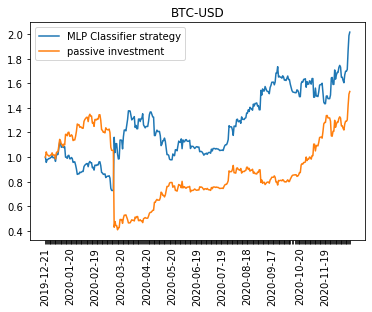

In [211]:
#plot figure
str_index = index.strftime(date_format='%Y-%m-%d')
fig, ax=plt.subplots()
plt.plot(index, mlp, label='MLP Classifier strategy')
plt.plot(index, passive, label='passive investment')
plt.xticks(str_index)
plt.xticks(rotation=90)
plt.title("BTC-USD")
plt.legend()

every_nth = 30
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

In [246]:
# calculate trading strategy volatility and Sharpe ratio (annualised)
strategy_return=np.zeros(length)
for i in range(0,length-1):
    strategy_return[i]=mlp[i+1]/mlp[i]-1
std_strategy=strategy_return.std()*np.sqrt(length)
std_invest=ret.std()*np.sqrt(length)
ret_strategy=(mlp[-1]/mlp[0]-1)
ret_invest=(passive[-1]/passive[0]-1)
rf= 1.56/100
SR_strategy=(ret_strategy-rf)/std_strategy
SR_invest=(ret_invest-rf)/std_invest
print("Return: strategy ",ret_strategy, " investment ", ret_invest)
print("Standard deviation: strategy ",std_strategy, " investment ", std_invest)
print("Sharpe ratio: strategy ",SR_strategy, " investment ", SR_invest)

Return: strategy  1.0148547318286276  investment  0.5328026930370158
Standard deviation: strategy  0.04806643701857564  investment  0.07620883839639513
Sharpe ratio: strategy  20.78903271824492  investment  6.786649736698792
